<a href="https://colab.research.google.com/github/wonjerry/DCGAN/blob/master/dcgan_tensorflow_fashionMNIST_5layer_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DCGAN](https://hyeongminlee.github.io/post/gan003_dcgan/)

# Hyper-Parameters
- Image Size = 32x32
- Batch Size = 64 (~32 is OK)
- Learning Rate = 0.0002
- Adam_beta1 = 0.5
- z_dim = 100
- Epoch = 5


Using TensorFlow backend.


1.13.1
(60000, 28, 28, 1)


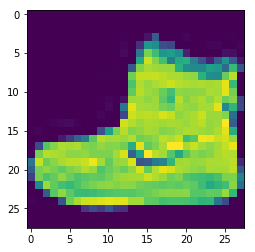

In [0]:
import tensorflow as tf
import numpy as np
import os
import scipy.misc
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.datasets import mnist
import PIL
import matplotlib

print(tf.VERSION)

# y_train_은 라벨임
(x_train, y_train_), (x_test, y_test_) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

print(x_train.shape)
img2 = np.reshape(x_train[0], [28, 28])
plt.imshow(img2)
plt.show()

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
RESULT_DIR = '/content/gdrive/My Drive/results'
CKPT_DIR = RESULT_DIR + '/ckpt'

In [0]:

def save_visualization(X, nh_nw, save_path='/content/gdrive/My Drive/results/sample.jpg'):
    nh, nw = nh_nw
    h, w = X.shape[1], X.shape[2]
    img = np.zeros((h * nh, w * nw, 3))

    for n, x in enumerate(X):
        j = int(n / nw)
        i = int(n % nw)
        img[j * h:j * h + h, i * w:i * w + w, :] = x

    matplotlib.image.imsave(save_path, img)

#     scipy.misc.imsave(save_path, img)

In [0]:
# Class for batch normalization node
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum,
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name,
                                            reuse=tf.AUTO_REUSE  # if tensorflow vesrion < 1.4, delete this line
                                            )

In [0]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)
  

def discriminator_loss(loss_func, real, fake):
    real_loss = 0
    fake_loss = 0

    if loss_func.__contains__('wgan') :
        real_loss = -tf.reduce_mean(real)
        fake_loss = tf.reduce_mean(fake)

    if loss_func == 'lsgan' :
        real_loss = tf.reduce_mean(tf.squared_difference(real, 1.0))
        fake_loss = tf.reduce_mean(tf.square(fake))

    if loss_func == 'gan' or loss_func == 'dragan' :
        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake), logits=fake))

    if loss_func == 'hinge' :
        real_loss = tf.reduce_mean(relu(1.0 - real))
        fake_loss = tf.reduce_mean(relu(1.0 + fake))
        
    if loss_func == 'focal' :
        gamma = 2.0
        real_loss = -tf.reduce_mean(((1 - real)**gamma) * tf.log(real))
        fake_loss = -tf.reduce_mean(((1 - (1 - fake))**gamma) * tf.log(1 - fake))

    loss = real_loss + fake_loss

    return loss

def generator_loss(loss_func, fake):
    fake_loss = 0

    if loss_func.__contains__('wgan') :
        fake_loss = -tf.reduce_mean(fake)

    if loss_func == 'lsgan' :
        fake_loss = tf.reduce_mean(tf.squared_difference(fake, 1.0))

    if loss_func == 'gan' or loss_func == 'dragan' :
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake), logits=fake))

    if loss_func == 'hinge' :
        fake_loss = -tf.reduce_mean(fake)
        
    if loss_func == 'focal' :
        gamma = 2.0
        fake_loss = -tf.reduce_mean(((1 - (1 - fake))**gamma) * tf.log(1 - fake))

    loss = fake_loss

    return loss

In [0]:
# leaky relu function
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

In [0]:
class DCGAN:
    # Network Parameters
    def __init__(self, sess, batch_size):
        self.learning_rate = 0.0002
        self.generator_learning_rate = 1e-3
        self.discriminator_learning_rate = 0.0002

        self.sess = sess

        self.batch_size = batch_size

        self.image_shape = [28, 28, 1]

        self.dim_z = 100
        self.dim_W1 = 1024
        self.dim_W2 = 512
        self.dim_W3 = 128
        self.dim_W4 = 16
        self.dim_W5 = 1

        self.G_W1 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W1, self.dim_z], stddev=0.02), name="G_W1")
        self.G_bn1 = batch_norm(name="G_bn1")

        self.G_W2 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W2, self.dim_W1], stddev=0.02), name='G_W2')
        self.G_bn2 = batch_norm(name="G_bn2")

        self.G_W3 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W3, self.dim_W2], stddev=0.02), name='G_W3')
        self.G_bn3 = batch_norm(name="G_bn3")
        
        self.G_W4 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W4, self.dim_W3], stddev=0.02), name='G_W3')
        self.G_bn4 = batch_norm(name="G_bn4")

        self.G_W5 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W5, self.dim_W4], stddev=0.02), name='G_W4')

        self.D_W1 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W5, self.dim_W4], stddev=0.02), name='D_W1')

        self.D_W2 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W4, self.dim_W3], stddev=0.02), name='D_W2')
        self.D_bn2 = batch_norm(name="D_bn2")

        self.D_W3 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W3, self.dim_W2], stddev=0.02), name='D_W3')
        self.D_bn3 = batch_norm(name="D_bn3")
        
        self.D_W4 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W2, self.dim_W1], stddev=0.02), name='D_W4')
        self.D_bn4 = batch_norm(name="D_bn4")

        self.D_W5 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W1, 1], stddev=0.02), name='D_W5')

        self.gen_params = [
            self.G_W1,
            self.G_W2,
            self.G_W3,
            self.G_W4,
            self.G_W5
        ]

        self.discrim_params = [
            self.D_W1,
            self.D_W2,
            self.D_W3,
            self.D_W4,
            self.D_W5
        ]
        
        self.saver = tf.train.Saver()

        self._build_model()
        
    def _build_model(self):
        self.Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z])

        self.image_real = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape)
        image_gen = self.generate(self.Z)

        d_real = self.discriminate(self.image_real)
        d_gen = self.discriminate(image_gen)

        self.discrim_cost = discriminator_loss('hinge', d_real, d_gen)
        self.gen_cost = generator_loss('hinge', d_gen)

        self.train_op_discrim = tf.train.AdamOptimizer(self.discriminator_learning_rate, beta1=0.5).minimize(self.discrim_cost, var_list=self.discrim_params)
        self.train_op_gen = tf.train.AdamOptimizer(self.generator_learning_rate, beta1=0.5).minimize(self.gen_cost, var_list=self.gen_params)
        
    def generate(self, Z):
        h1 = tf.reshape(Z, [self.batch_size, 1, 1, self.dim_z])
        h1 = tf.nn.conv2d_transpose(h1, self.G_W1, output_shape=[self.batch_size, 2, 2, self.dim_W1],
                                    strides=[1, 4, 4, 1])
        h1 = tf.nn.relu(self.G_bn1(h1))

        h2 = tf.nn.conv2d_transpose(h1, self.G_W2, output_shape=[self.batch_size, 4, 4, self.dim_W2],
                                    strides=[1, 2, 2, 1])
        h2 = tf.nn.relu(self.G_bn2(h2))

        h3 = tf.nn.conv2d_transpose(h2, self.G_W3, output_shape=[self.batch_size, 7, 7, self.dim_W3],
                                    strides=[1, 2, 2, 1])
        h3 = tf.nn.relu(self.G_bn3(h3))
        
        h4 = tf.nn.conv2d_transpose(h3, self.G_W4, output_shape=[self.batch_size, 14, 14, self.dim_W4],
                                    strides=[1, 2, 2, 1])
        h4 = tf.nn.relu(self.G_bn4(h4))
        
        h5 = tf.nn.conv2d_transpose(h4, self.G_W5, output_shape=[self.batch_size, 28, 28, self.dim_W5],
                                    strides=[1, 2, 2, 1])
        x = tf.nn.tanh(h5)
        return x
      
    def discriminate(self, image):
        h1 = lrelu(tf.nn.conv2d(image, self.D_W1, strides=[1, 2, 2, 1], padding='SAME'))
        h2 = lrelu(self.D_bn2(tf.nn.conv2d(h1, self.D_W2, strides=[1, 2, 2, 1], padding='SAME')))
        h3 = lrelu(self.D_bn3(tf.nn.conv2d(h2, self.D_W3, strides=[1, 2, 2, 1], padding='SAME')))
        h4 = lrelu(tf.nn.conv2d(h3, self.D_W4, strides=[1, 2, 2, 1], padding='SAME'))
        h5 = lrelu(tf.nn.conv2d(h4, self.D_W5, strides=[1, 4, 4, 1], padding='SAME'))
        y = tf.nn.sigmoid(h5)
        return y
      
    def sample_generator(self, noise_z, batch_size=1):
        noise_z = np.array(noise_z).reshape([batch_size, self.dim_z])

        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z])
        h1 = tf.reshape(Z, [batch_size, 1, 1, self.dim_z])
        h1 = tf.nn.conv2d_transpose(h1, self.G_W1, output_shape=[batch_size, 2, 2, self.dim_W1],
                                    strides=[1, 4, 4, 1])
        h1 = tf.nn.relu(self.G_bn1(h1))

        output_shape_l2 = [batch_size, 4, 4, self.dim_W2]
        h2 = tf.nn.conv2d_transpose(h1, self.G_W2, output_shape=output_shape_l2, strides=[1, 2, 2, 1])
        h2 = tf.nn.relu(self.G_bn2(h2))

        output_shape_l3 = [batch_size, 7, 7, self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.G_W3, output_shape=output_shape_l3, strides=[1, 2, 2, 1])
        h3 = tf.nn.relu(self.G_bn3(h3))

        output_shape_l4 = [batch_size, 14, 14, self.dim_W4]
        h4 = tf.nn.conv2d_transpose(h3, self.G_W4, output_shape=output_shape_l4, strides=[1, 2, 2, 1])
        h4 = tf.nn.relu(self.G_bn4(h4))
        
        output_shape_l5 = [batch_size, 28, 28, self.dim_W5]
        h5 = tf.nn.conv2d_transpose(h4, self.G_W5, output_shape=output_shape_l5, strides=[1, 2, 2, 1])
        x = tf.nn.tanh(h5)

        generated_samples = self.sess.run(x, feed_dict={Z: noise_z})
        generated_samples = (generated_samples + 1.) / 2.
        return generated_samples
      
    def train_gen(self, noise_z):
        _, loss_val_G = self.sess.run([self.train_op_gen, self.gen_cost], feed_dict={self.Z: noise_z})
        return loss_val_G

    def train_discrim(self, batch_xs, noise_z):
        _, loss_val_D = self.sess.run([self.train_op_discrim, self.discrim_cost],
                                      feed_dict={self.image_real: batch_xs, self.Z: noise_z})
        return loss_val_D


In [0]:
def main(ckpt_name=None):
  total_epoch = 1000
  batch_size = 256
  n_noise = 100

  sess = tf.Session()
  model = DCGAN(sess, batch_size)
  sess.run(tf.global_variables_initializer())

  total_batch = int(x_train.shape[0] / batch_size)
  print('total_batch: ', total_batch)

  visualization_num = 14 * 14
  noise_test = np.random.normal(size=(visualization_num, n_noise))

  loss_D = 0.0
  loss_G = 0.0
  start = 0

  ckpt_path = tf.train.latest_checkpoint(CKPT_DIR)
  print(ckpt_path)
  
  if ckpt_path is not None:
    model.saver.restore(sess, tf.train.latest_checkpoint(CKPT_DIR))
    start = int(ckpt_path[-1]) + 1
    print('start: ',  start)

  for epoch in range(start, total_epoch):
    for step in range(total_batch):
      batch_xs = x_train[step * batch_size:(step + 1) * batch_size] # Get the next batch
      batch_xs = batch_xs * (2.0 / 255.0) - 1
      noise_g = np.random.normal(size=(batch_size, n_noise))
      noise_d = np.random.normal(size=(batch_size, n_noise))

      # Train Generator twice while epoch % 2 == 0
      if epoch % 2 == 0:
          adventage = 2
      else:
          adventage = 1

      if step % adventage == 0:
          # Train Discriminator and get the loss value
          loss_D = model.train_discrim(batch_xs, noise_d)     
      # Train Generator and get the loss value
      loss_G = model.train_gen(noise_g)

      print('Epoch: [', epoch + 1, '/', total_epoch, '], ', 'Step: [', step + 1, '/', total_batch, '], D_loss: ',
            loss_D, ', G_loss: ', loss_G)
      if step == 0 or (step + 1) % 100 == 0:
          generated_samples = model.sample_generator(noise_test, batch_size=visualization_num)
          print(generated_samples.shape)
          ex_img = np.reshape(generated_samples[0], [28, 28])
          plt.imshow(ex_img)
          plt.show()
          savepath = RESULT_DIR + '/output_' + 'EP' + str(epoch).zfill(3) + "_Batch" + str(step + 1).zfill(6) + '.jpg'
          save_visualization(generated_samples, (14, 14), save_path=savepath)
    
    # TODO(wonjerry): make checkpoint name configurable
    model.saver.save(sess, (CKPT_DIR + '/model_test'), epoch)  

main()
